Car Path: [33, 14, 16, 37, 22, 39, 2]
Ambulance Path: [38, 29, 22, 7, 19]


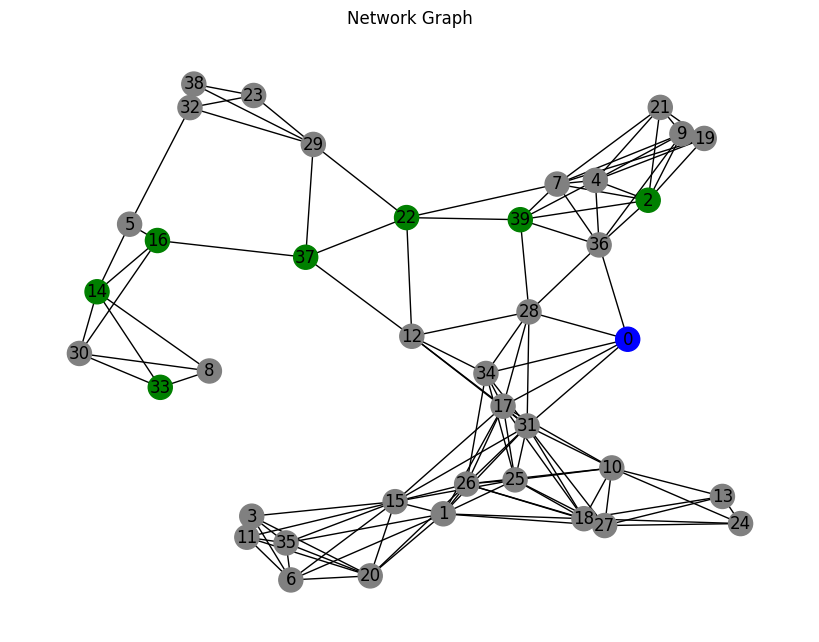

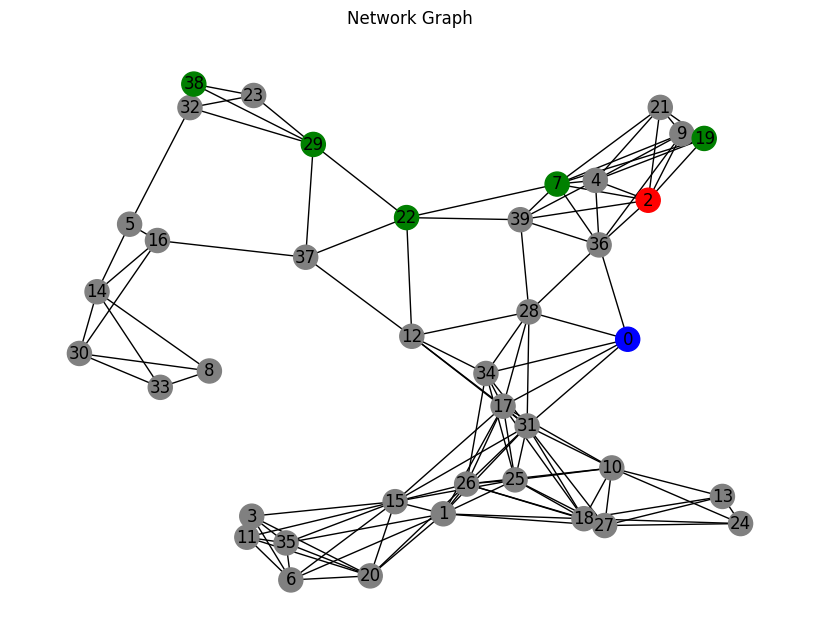

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import math
import heapq
import time
from multiprocessing import Pool

# --- Map Class ---
class Map:
    def __init__(self, G):
        self._graph = G
        self.intersections = nx.get_node_attributes(G, "pos")
        self.roads = [list(G.neighbors(node)) for node in G.nodes()]

# --- Load Map Function ---
def load_map_graph(map_dict):
    G = nx.Graph()
    for node in map_dict.keys():
        G.add_node(node, pos=map_dict[node]['pos'])
    for node in map_dict.keys():
        for con_node in map_dict[node]['connections']:
            G.add_edge(node, con_node)
    return G

# --- Traffic Light Manager (Simulates real-time traffic light cycles) ---
class TrafficLightManager:
    def __init__(self, cycle_time=30):
        self.cycle_time = cycle_time
        self.start_time = time.time()

    def get_light_delay(self, node):
        elapsed_time = (time.time() - self.start_time) % self.cycle_time
        return self.cycle_time - elapsed_time if elapsed_time < (self.cycle_time / 2) else 0

# --- A* Pathfinding with Traffic Lights ---
class PathPlanner():
    def __init__(self, M, start, goal, heuristic_weight=1.0, traffic_lights=None, vehicle_type="car"):
        self.map = M
        self.start = start
        self.goal = goal
        self.heuristic_weight = heuristic_weight
        self.traffic_lights = traffic_lights if traffic_lights else {node: 0 for node in M.intersections.keys()}
        self.vehicle_type = vehicle_type
        self.openSet = []
        self.closedSet = set()
        self.cameFrom = {}
        self.gScore = {node: float('inf') for node in M.intersections.keys()}
        self.fScore = {node: float('inf') for node in M.intersections.keys()}
        self.gScore[start] = 0
        self.fScore[start] = self.heuristic_cost_estimate(start)
        heapq.heappush(self.openSet, (self.fScore[start], start))
        self.path = self.run_search()

    def run_search(self):
        while self.openSet:
            current = heapq.heappop(self.openSet)[1]
            if current == self.goal:
                return list(reversed(self.reconstruct_path(current)))
            self.closedSet.add(current)
            for neighbor in self.get_neighbors(current):
                if neighbor in self.closedSet:
                    continue
                tentative_gScore = self.get_tentative_gScore(current, neighbor)
                if tentative_gScore >= self.gScore[neighbor]:
                    continue
                self.cameFrom[neighbor] = current
                self.gScore[neighbor] = tentative_gScore
                self.fScore[neighbor] = tentative_gScore + self.heuristic_cost_estimate(neighbor)
                heapq.heappush(self.openSet, (self.fScore[neighbor], neighbor))
        print("No Path Found")
        return None

    def reconstruct_path(self, current):
        total_path = [current]
        while current in self.cameFrom:
            current = self.cameFrom[current]
            total_path.append(current)
        return total_path

    def get_neighbors(self, node):
        return set(self.map.roads[node])

    def get_tentative_gScore(self, current, neighbor):
        base_cost = self.gScore[current] + self.distance(current, neighbor)
        waiting_cost = 0 if self.vehicle_type == "ambulance" else self.traffic_lights.get(neighbor, 0)
        return base_cost + waiting_cost

    def heuristic_cost_estimate(self, node):
        return self.heuristic_weight * self.distance(node, self.goal)

    def distance(self, node_1, node_2):
        x1, y1 = self.map.intersections[node_1]
        x2, y2 = self.map.intersections[node_2]
        return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# --- Parallel Processing for Multiple Routes ---
def find_path_parallel(args):
    return PathPlanner(*args).path

def parallel_experiment(map_obj, starts, goals, heuristic_weight=1.0, traffic_lights=None):
    tasks = [(map_obj, s, g, heuristic_weight, traffic_lights) for s, g in zip(starts, goals)]
    with Pool(processes=4) as pool:
        results = pool.map(find_path_parallel, tasks)
    return results

# --- Visualization ---
def show_map(M, start=None, goal=None, path=None):
    G = M._graph
    pos = nx.get_node_attributes(G, 'pos')
    node_colors = []
    for node in G.nodes():
        if path and node in path:
            node_colors.append("green")
        elif node == start:
            node_colors.append("blue")
        elif node == goal:
            node_colors.append("red")
        else:
            node_colors.append("gray")
    plt.figure(figsize=(8,6))
    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='black', node_size=300)
    plt.title("Network Graph")
    plt.show()

# --- Example Usage ---
if __name__ == "__main__":
    # Load the map
    map_dict = {
    0: {'pos': (0.7801603911549438, 0.49474860768712914), 'connections': [36, 34, 31, 28, 17]},
    1: {'pos': (0.5249831588690298, 0.14953665513987202), 'connections': [35, 31, 27, 26, 25, 20, 18, 17, 15, 6]},
    2: {'pos': (0.8085335344099086, 0.7696330846542071), 'connections': [39, 36, 21, 19, 9, 7, 4]},
    3: {'pos': (0.2599134798656856, 0.14485659826020547), 'connections': [35, 20, 15, 11, 6]},
    4: {'pos': (0.7353838928272886, 0.8089961609345658), 'connections': [39, 36, 21, 19, 9, 7, 2]},
    5: {'pos': (0.09088671576431506, 0.7222846879290787), 'connections': [32, 16, 14]},
    6: {'pos': (0.313999018186756, 0.01876171413125327), 'connections': [35, 20, 15, 11, 1, 3]},
    7: {'pos': (0.6824813442515916, 0.8016111783687677), 'connections': [39, 36, 22, 21, 19, 9, 2, 4]},
    8: {'pos': (0.20128789391122526, 0.43196344222361227), 'connections': [33, 30, 14]},
    9: {'pos': (0.8551947714242674, 0.9011339078096633), 'connections': [36, 21, 19, 2, 4, 7]},
    10: {'pos': (0.7581736589784409, 0.24026772497187532), 'connections': [31, 27, 26, 25, 24, 18, 17, 13]},
    11: {'pos': (0.25311953895059136, 0.10321622277398101), 'connections': [35, 20, 15, 3, 6]},
    12: {'pos': (0.4813859169876731, 0.5006237737207431), 'connections': [37, 34, 31, 28, 22, 17]},
    13: {'pos': (0.9112422509614865, 0.1839028760606296), 'connections': [27, 24, 18, 10]},
    14: {'pos': (0.04580558670435442, 0.5886703168399895), 'connections': [33, 30, 16, 5, 8]},
    15: {'pos': (0.4582523173083307, 0.1735506267461867), 'connections': [35, 31, 26, 25, 20, 17, 1, 3, 6, 11]},
    16: {'pos': (0.12939557977525573, 0.690016328140396), 'connections': [37, 30, 5, 14]},
    17: {'pos': (0.607698913404794, 0.362322730884702), 'connections': [34, 31, 28, 26, 25, 18, 0, 1, 10, 12, 15]},
    18: {'pos': (0.719569201584275, 0.13985272363426526), 'connections': [31, 27, 26, 25, 24, 1, 10, 13, 17]},
    19: {'pos': (0.8860336256842246, 0.891868301175821), 'connections': [21, 2, 4, 7, 9]},
    20: {'pos': (0.4238357358399233, 0.026771817842421997), 'connections': [35, 26, 1, 3, 6, 11, 15]},
    21: {'pos': (0.8252497121120052, 0.9532681441921305), 'connections': [2, 4, 7, 9, 19]},
    22: {'pos': (0.47415009287034726, 0.7353428557575755), 'connections': [39, 37, 29, 7, 12]},
    23: {'pos': (0.26253385360950576, 0.9768234503830939), 'connections': [38, 32, 29]},
    24: {'pos': (0.9363713903322148, 0.13022993020357043), 'connections': [27, 10, 13, 18]},
    25: {'pos': (0.6243437191127235, 0.21665962402659544), 'connections': [34, 31, 27, 26, 1, 10, 15, 17, 18]},
    26: {'pos': (0.5572917679006295, 0.2083567880838434), 'connections': [34, 31, 27, 1, 10, 15, 17, 18, 20, 25]},
    27: {'pos': (0.7482655725962591, 0.12631654071213483), 'connections': [31, 1, 10, 13, 18, 24, 25, 26]},
    28: {'pos': (0.6435799740880603, 0.5488515965193208), 'connections': [39, 36, 34, 31, 0, 12, 17]},
    29: {'pos': (0.34509802713919313, 0.8800306496459869), 'connections': [38, 37, 32, 22, 23]},
    30: {'pos': (0.021423673670808885, 0.4666482714834408), 'connections': [33, 8, 14, 16]},
    31: {'pos': (0.640952694324525, 0.3232711412508066), 'connections': [34, 0, 1, 10, 12, 15, 17, 18, 25, 26, 27, 28]},
    32: {'pos': (0.17440205342790494, 0.9528527425842739), 'connections': [38, 5, 23, 29]},
    33: {'pos': (0.1332965908314021, 0.3996510641743197), 'connections': [8, 14, 30]},
    34: {'pos': (0.583993110207876, 0.42704536740474663), 'connections': [0, 12, 17, 25, 26, 28, 31]},
    35: {'pos': (0.3073865727705063, 0.09186645974288632), 'connections': [1, 3, 6, 11, 15, 20]},
    36: {'pos': (0.740625863119245, 0.68128520136847), 'connections': [39, 0, 2, 4, 7, 9, 28]},
    37: {'pos': (0.3345284735051981, 0.6569436279895382), 'connections': [12, 16, 22, 29]},
    38: {'pos': (0.17972981733780147, 0.999395685828547), 'connections': [23, 29, 32]},
    39: {'pos': (0.6315322816286787, 0.7311657634689946), 'connections': [2, 4, 7, 22, 28, 36]}
    }
    map_obj = Map(load_map_graph(map_dict))
    
    # Initialize Traffic Light Manager
    traffic_light_manager = TrafficLightManager(cycle_time=20)
    traffic_light_states = {node: traffic_light_manager.get_light_delay(node) for node in map_obj.intersections.keys()}
    
    # Run A* with different vehicle types
    car_path = PathPlanner(map_obj, start=33, goal=2, vehicle_type="car", traffic_lights=traffic_light_states).path
    ambulance_path = PathPlanner(map_obj, start=38, goal=19, vehicle_type="ambulance", traffic_lights=traffic_light_states).path
    
    print("Car Path:", car_path)
    print("Ambulance Path:", ambulance_path)
    show_map(map_obj, start=0, goal=2, path=car_path)
    show_map(map_obj, start=0, goal=2, path=ambulance_path)
    
